In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
from net import Net
from dataset import get_caption_dataset
%matplotlib inline

In [2]:
batch_size = 8
image_size = 224
hidden_dim = 512
num_layers = 1

data_root = "./data"
ckpt_path = "./checkpoint/caption_200.pth"

In [3]:
# to initialize vocab
_, _, TEXT = get_caption_dataset(
    train=True,
    data_root=data_root,
    batch_size=batch_size, image_size=image_size,
    text_field=True)

loader, dataset = get_caption_dataset(
    train=False,
    data_root=data_root,
    batch_size=batch_size, image_size=image_size, shuffle=False)

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = Net(TEXT, hidden_dim, num_layers).to(device)

# load pre-trained model
state_dict = torch.load(ckpt_path)
net.load_state_dict(state_dict)

<All keys matched successfully>

In [5]:
net.eval()
cap_repr, pred_repr = list(), list()
with torch.no_grad():
    for inputs in loader:
        image   = inputs[0].to(device)
        caption = inputs[1]
        
        preds = net.sample(image)
        print(preds)
        for pred, cap in zip(preds, caption):
            cap_sent, cap_words = dataset.indices_to_string(cap, True)
            pred_sent, pred_words = dataset.indices_to_string(pred, True)
            
            cap_repr.append(cap_sent)
            pred_repr.append(pred_sent)
            
        break # run only first batch

[[  2  13   6  12   4  73  22  38  17  26   5  28   8   3   3   8   3   3
   21   8   3   3   8   3  21   8   3   7   5  37   7   5 145  12   4  16
   78  74   8   3  17  44   5  50  67  28  29   8   3  17]
 [  2  14  17   4  42  65   6   9   4  73  55   5   4 126   7 104  10  18
    5  58  17   4 170  63  47  79   9   4  11  97  31  13  91   8   3   3
   37   8   3   8   3  17 145  52   5  38  17   4 269 269]
 [  2  14  17   4  26   6   9   4  10  23   5   4  83  18   8   3   8   3
   53  25  29 115   8   3   7   9  11   7  33  37   5  54  30  18   8   3
    9 121  37   8   3   8   3 119  13 105  35  13  29   8]
 [  2  14   6  12   4  28 207   7  28 238   5 146 108   7  11  24   5  56
    7   4  28  18   8   3   6   8   3   8   3  35  13  34  79   7  10   7
    5  11   8   3   3  17  61  65  60 363   8   3   7  37]
 [  2  61  65   6   9   4  11  29  38 424  60  53  26  32 109  25  18  53
   25  36   8   3   3   8   3   3   8   3  17 145  10  21   5 145  12   4
   11 150  35  13  75   

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


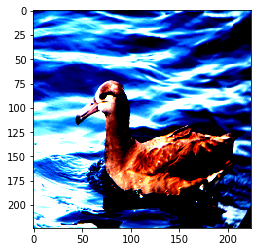

In [33]:
im = image[2]
im = im.cpu().numpy()
im = np.transpose(im,(1,2,0))
plt.imshow(im)
plt.show()

In [6]:
def inverse_transform(image):
    transform = transforms.Normalize((-2.12, -2.04, -1.80), (4.37, 4.46, 4.44))
    image = image.clone()
    image = transform(image).mul(255).clamp_(0, 255)
    
    return image.byte().permute(1, 2, 0).cpu().numpy()

def pretty_print(string, width=100):
    new_string = ""
    for i in range(0, len(string), width):
        new_string += string[i:i+width]
        
        if i+width < len(string):
            new_string += "\n"
    return new_string

In [7]:
pred_repr

['the bird has a curved bill that is grey and long.',
 'this is a large sized bird with a curved neck and a straight, flat black beak and all is a brownish - green color with a white stripe on the face.',
 'this is a grey bird with a black head and a pointy beak.',
 'this bird has a long wingspan, long inner and outer rectrices, white breast and nape, a long beak.',
 'medium sized bird with a white body that turns in to grey feathers from its beak to its tail.',
 'the bird is black and grey speckled with a beak that has a black point.',
 'the bird has a long bill that is red, as well as large wingbars.',
 'this is a large grey bird with a black face and beak.']

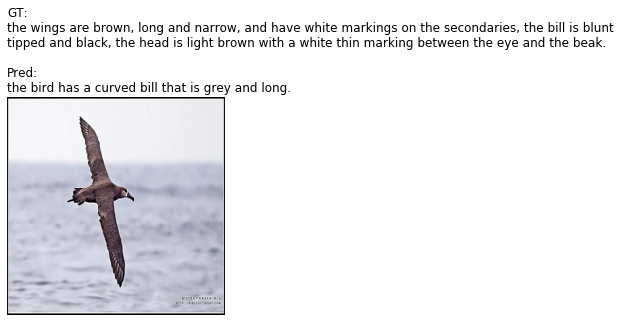

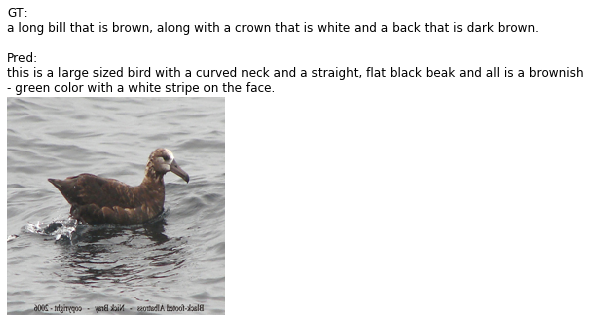

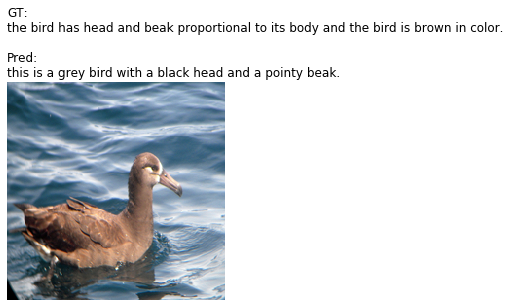

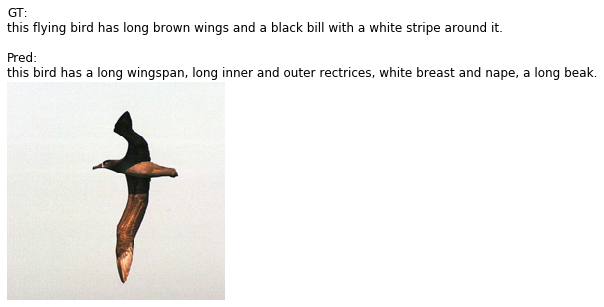

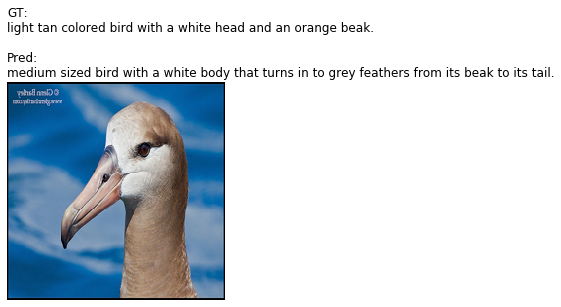

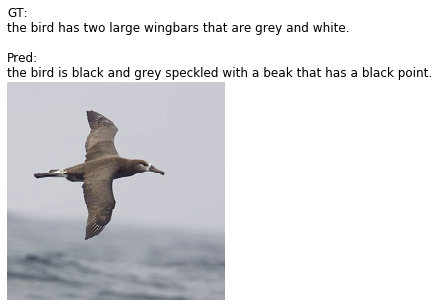

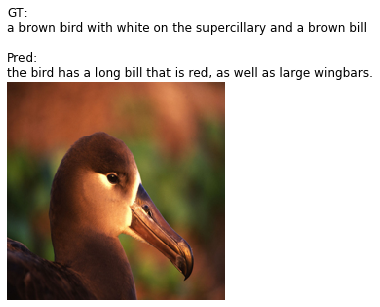

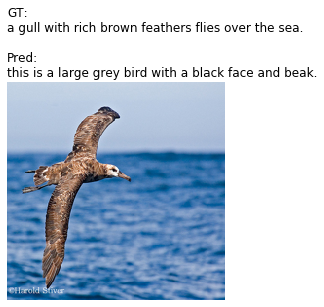

In [8]:
# visualize first batch
for i, (im, cap, pred) in enumerate(zip(image, cap_repr, pred_repr)):
    im = inverse_transform(im)
    
    cap = pretty_print(cap)
    pred = pretty_print(pred)
    
    sentence = "GT:\n{}\n\nPred:\n{}".format(cap, pred)
    
    fig = plt.figure()
    plt.title(sentence, loc="left")
    plt.imshow(im)
    plt.axis("off")